<a href="https://colab.research.google.com/github/AIKevin/Sentence_Classification_for_PGN/blob/master/Projet_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sentence Classification for Pointer Generator Network

For this notebook you will need:


1.   One dataset of annotated data with the class of the sentence (important or non-important)
2.   One folder with csv files containing sentences to classify before making the raw data for the Pointer Generator Network



In [257]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
!pip install tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 58kB/s 
     |████████████████████████████████| 501kB 43.0MB/s 
     |████████████████████████████████| 3.1MB 32.5MB/s 


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
from google.colab import files
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import os
import io
import keras.preprocessing.text
import tensorflow.keras.backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import multilabel_confusion_matrix as mcm
tf.keras.backend.clear_session()
np.set_printoptions(precision=3, suppress=True)
pd.options.display.max_colwidth = 1000

In [0]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

#Data Preprocess
For this part you will need:


1.   Raw dataset of sentences (xlsx format)



In [0]:
def create_dataset(TRAIN_DATA_PATH):
  #TEST_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/eval.csv"

  train_file_path = pd.read_excel(TRAIN_DATA_PATH, sep=';', encoding='latin-1', header=0)
  msk = np.random.rand(len(train_file_path)) < 0.8

  train = train_file_path[msk]

  test = train_file_path[~msk]
  #print(train_file_path.head)
  all_data = np.array(train_file_path.values.tolist())
  training_set = np.array(train.values.tolist())
  test_set=np.array(test.values.tolist())
  print("Dataset Length: ",len(training_set)+ len(test_set))
  return all_data, training_set, test_set

In [0]:
def create_tokenizer(dataset):
  # create the tokenizer
  tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token='UNK')
  # fit the tokenizer on the documents
  tokenizer.fit_on_texts(all_data[:,1])
  # summarize what was learned
  print("Word counter: ",tokenizer.word_counts)
  print("Number of sentences: ",tokenizer.document_count)
  print("Word Index: ", tokenizer.word_index)
  print("Word Docs: ",tokenizer.word_docs)
  return tokenizer

In [0]:
def reverser():
  reverse_word_index = dict([(value, key) for (key, value) in tokenizer.word_index.items()])
  return reverse_word_index

In [0]:
def vocab_size(tokenizer):
  vocab_size=len(tokenizer.word_counts)+2
  return vocab_size

In [0]:
def maxlen(training, test):
  max_train_sequence_len = max([len(x) for x in training])
  max_test_sequence_len = max([len(x) for x in test])
  return max(max_train_sequence_len, max_test_sequence_len)

In [7]:
all_data, training_set, test_set = create_dataset("/content/drive/My Drive/Datasets/donnee4.xlsx")

Dataset Length:  2398


In [9]:
tokenizer=create_tokenizer(all_data)

Word counter:  OrderedDict([('présenté', 4), ('officiellement', 2), ('comme', 33), ('nouveau', 53), ('joueur', 19), ('du', 1225), ('psg', 54), ('neymar', 78), ('effectue', 25), ('ses', 108), ('premiers', 12), ('pas', 197), ('avec', 403), ('le', 2590), ('club', 16), ('parisien', 18), ('cet', 15), ('après', 215), ('midi', 4), ('retrouvez', 2), ('les', 639), ('détails', 2), ('de', 3655), ('événement', 2), ('majeur', 2), ('but', 876), ("d'edinson", 12), ('cavani', 89), ('concrétise', 26), ('avant', 181), ('la', 2108), ('pause', 71), ('sur', 1428), ('un', 806), ('centre', 415), ('proposé', 6), ('côté', 473), ('droit', 758), ('par', 659), ('daniel', 21), ('alves', 29), ('matador', 6), ('contrôle', 119), ('genou', 19), ('efface', 7), ('prince', 6), ('gouano', 9), ('et', 1619), ('termine', 65), ('tir', 155), ('croisé', 40), ('à', 1529), ('ras', 120), ('terre', 104), ('pied', 485), ('gauche', 837), ('petit', 96), ('filet', 81), ('opposé', 35), ('javier', 12), ('pastore', 29), ('paris', 59), ('s

#Embeddings pretraining (Next Word Prediction)
For this part you will need:


1.   Preprocessed dataset
2.   Tokenizer from the data preprocess part



In [0]:
def tokenize_and_split_sentences(input_set):
  input_sequences = []
  for line in input_set[:,1]:
      token_list = tokenizer.texts_to_sequences([line])[0]
      for i in range(1, len(token_list)):
          n_gram_sequence = token_list[:i+1]
          input_sequences.append(n_gram_sequence)
  return input_sequences
  #print(input_test_sequences)

In [0]:
def pad_sentences(input_sequences, max_sequence_len):
  input_padded_sequences = np.array(pad_sequences(input_sequences,   
                            maxlen=max_sequence_len, padding='pre'))
  return input_padded_sequences


In [0]:
def create_dataset_slices(input_sequences):
  predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
  label = keras.utils.to_categorical(label, num_classes=vocab_size)
  return predictors, label

In [0]:
def create_preprocessed_dataset(predictors, labels):
  dataset = tf.data.Dataset.from_tensor_slices((predictors, labels))
  return dataset

In [0]:
def prepare_train_dataset(train_dataset, BUFFER_SIZE, BATCH_SIZE):
  train_dataset = train_dataset.shuffle(BUFFER_SIZE)
  train_dataset = train_dataset.padded_batch(BATCH_SIZE, train_dataset.output_shapes)
  return train_dataset
def prepare_test_dataset(test_dataset, BATCH_SIZE):
  test_dataset = test_dataset.padded_batch(BATCH_SIZE, test_dataset.output_shapes)
  return test_dataset

In [0]:
def top_k_categorical_accuracy2(y_true, y_pred, k=50):
    return K.mean(K.in_top_k(K.cast(y_pred,dtype='float32'), K.argmax(y_true, axis=-1), k), axis=-1)

In [0]:
def get_embeddings(model):
  e = model.layers[0]
  weights = e.get_weights()[0]
  return weights

In [0]:
def write_tsv_for_visualization(weights):
  out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
  out_m = io.open('meta.tsv', 'w', encoding='utf-8')
  for word_num in range(vocab_size):
    if word_num==0:
      word = "PAD"
      embeddings = weights[word_num]
    else:
      reverse_word_index=reverser()
      word = reverse_word_index[word_num]
      embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
  out_v.close()
  out_m.close()
  files.download('vecs.tsv')
  files.download('meta.tsv')

In [0]:
input_train=tokenize_and_split_sentences(training_set)
input_test=tokenize_and_split_sentences(test_set)

In [0]:
vocab_size=vocab_size(tokenizer)

In [0]:
max_sequence_len=maxlen(input_train,input_test)

In [0]:
input_training_sequences=pad_sentences(input_train, max_sequence_len)

In [0]:
input_test_sequences=pad_sentences(input_test, max_sequence_len)

In [0]:
training_predictors, training_label=create_dataset_slices(input_training_sequences)

In [0]:
test_predictors, test_label= create_dataset_slices(input_test_sequences)

In [23]:
print(len(training_predictors))
print(len(test_predictors))
print(len(test_label))

56716
15433
15433


In [0]:
train_dataset=create_preprocessed_dataset(training_predictors,training_label)

In [0]:
test_dataset=create_preprocessed_dataset(test_predictors,test_label)

In [0]:
BUFFER_SIZE = 10000
BATCH_SIZE = 16

In [0]:
train_dataset=prepare_train_dataset(train_dataset, BUFFER_SIZE, BATCH_SIZE)
test_dataset= prepare_test_dataset(test_dataset, BATCH_SIZE)

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64),
    tf.keras.layers.LSTM(150),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(vocab_size, activation='softmax')
])

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[top_k_categorical_accuracy2])

In [33]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)

W0725 10:20:13.678402 140478070486912 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
3545/3545 [==============================] - 366s 103ms/step - loss: 6.3503 - top_k_categorical_accuracy2: 0.4772 - val_loss: 5.9724 - val_top_k_categorical_accuracy2: 0.5190
Epoch 2/10
3545/3545 [==============================] - 366s 103ms/step - loss: 5.2940 - top_k_categorical_accuracy2: 0.5998 - val_loss: 5.2932 - val_top_k_categorical_accuracy2: 0.6274
Epoch 3/10
3545/3545 [==============================] - 369s 104ms/step - loss: 4.5952 - top_k_categorical_accuracy2: 0.6884 - val_loss: 4.9753 - val_top_k_categorical_accuracy2: 0.6684
Epoch 4/10
3545/3545 [==============================] - 368s 104ms/step - loss: 4.0940 - top_k_categorical_accuracy2: 0.7558 - val_loss: 4.8045 - val_top_k_categorical_accuracy2: 0.6945
Epoch 5/10
3545/3545 [==============================] - 365s 103ms/step - loss: 3.6928 - top_k_categorical_accuracy2: 0.8110 - val_loss: 4.7383 - val_top_k_categorical_accuracy2: 0.7058
Epoch 6/10
3545/3545 [==============================] - 365s 103ms/ste

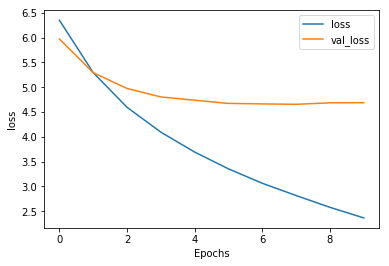

In [34]:
plot_graphs(history, 'loss')

In [0]:
w=get_embeddings(model)

In [37]:
w

array([[-0.372, -0.024,  0.111, ...,  0.03 , -0.024,  0.038],
       [-0.018, -0.017, -0.047, ..., -0.003,  0.027, -0.012],
       [ 0.091, -0.391, -0.015, ..., -0.043, -0.213,  0.098],
       ...,
       [ 0.288, -0.005, -0.006, ..., -0.146, -0.02 ,  0.028],
       [-0.213,  0.043,  0.092, ..., -0.066, -0.184, -0.148],
       [ 0.095,  0.113, -0.171, ...,  0.047,  0.039, -0.347]],
      dtype=float32)

In [0]:
#write_tsv_for_visualization(w)

#Sentence Selection
For this part you will need: 

1.   Pre-trained embeddings weights from the next word prediction
2.   Dataset of the next word prediction model (training_set and test_set) OR raw data which needs to be preprocessed (cf next word prediction part)
3.   Dataset of sentences to be classified



In [0]:
def tokenize_sentences(input_set):
  input_sequences = []
  for line in input_set[:,1]:
      token_list = tokenizer.texts_to_sequences([line])[0]
      input_sequences.append(token_list)
  return input_sequences

In [0]:
def pad_sentences2(input_sequences, max_sequence_len):
  input_padded_sequences=[]
  for line in input_sequences:
    padded_sequences =padarray(line, max_sequence_len)
    input_padded_sequences.append(padded_sequences)
  return input_padded_sequences

In [0]:
def create_dataset_slices_sentence_classification(input_sequences, targets):
  predictors= tf.constant(input_sequences)
  targets=targets.astype(int)
  nb_classes = 18
  targets = targets.reshape(-1)
  one_hot_targets = np.eye(nb_classes)[targets]
  return predictors, one_hot_targets

In [0]:
def padarray(A, size):
    t = size - len(A)
    return np.pad(A, pad_width=(0, t), mode='constant')

In [0]:
def sample_predict(sentence, pad, t, model):
  tokenized_sample_pred_text =t.texts_to_sequences([sentence])
  tokenized_sample_pred_text=np.array(tokenized_sample_pred_text)
  #print(len(tokenized_sample_pred_text[0]))     
  PAD_SIZE=80  
  if len(tokenized_sample_pred_text[0])<PAD_SIZE:
    inp=padarray(tokenized_sample_pred_text[0], PAD_SIZE)
    predictions = model.predict(tf.expand_dims(inp, 0)) 
    return np.argmax(predictions)
  else:
    return 17


In [0]:
#emb= pd.read_csv("vecs.tsv",sep='\t',header=None)
embeddings= np.array(w)
def retemb(shape, dtype=None):
  return embeddings

In [0]:
def create_dataset_PGN(folder_path, receiving_folder_path, add_score, tokenizer, model):
  folder_name=os.listdir(folder_path)
  num_match=0
  for file in folder_name:    
    i=0
    raw=pd.read_excel(folder_path+str(file), sep=';', encoding='latin-1', header=None)
    
    #print(raw[0])
    article=""
    for line in raw[0]:
      #print(line)
      if i==0:        
        score= str(line)
        print("score: ",score)
      if i==1:        
        summary= str(line)
        print("summary: ", summary)
      else:
      #print(line)
        predictions = sample_predict(str(line), True, tokenizer, model)
        #print(np.argmax(predictions))
        if predictions!=17:
          article+= " "+ str(line) 
      i+=1
    #print(summary)
    #print(article)
    resultat= score + article  +"\n"+ " @highlight " +"\n" + summary
    #print(resultat)
    with open(os.path.join(receiving_folder_path, "match"+str(num_match)+ ".story"), 'w') as writer:
      writer.write(resultat)
      num_match+=1
      
    #print(resultat)

In [0]:
input_train2=tokenize_sentences(training_set)
input_test2=tokenize_sentences(test_set)

In [0]:
input_training_sequences2=pad_sentences2(input_train2, max_sequence_len)
input_test_sequences2=pad_sentences2(input_test2,max_sequence_len)

In [130]:
input_training_sequences2[0]

array([1718, 2362,  326,  196,  563,    8,  189,  122,  435,   78,  843,
         49,   32,    3,  656,  593,  688,   45, 1719, 2363,   21, 2364,
          2,  688, 2365, 2366,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0])

In [0]:
training_predictors2, training_label2=create_dataset_slices_sentence_classification(input_training_sequences2,training_set[:,0])

In [0]:
test_predictors2, test_label2=create_dataset_slices_sentence_classification(input_test_sequences2,test_set[:,0])

In [0]:
train_dataset2=create_preprocessed_dataset(training_predictors2, training_label2)

In [0]:
test_dataset2=create_preprocessed_dataset(test_predictors2, test_label2)

In [136]:
for features_tensor, target_tensor in train_dataset2:
    print(f'features:{features_tensor} target:{target_tensor}')

features:[1718 2362  326  196  563    8  189  122  435   78  843   49   32    3
  656  593  688   45 1719 2363   21 2364    2  688 2365 2366    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0] target:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
features:[  11    2  845  376  174   29  347    9   40  543  348    2   24  231
    5  955    7    4   34   48  106   19  236    7    3   28   16   52
    2 3075    7   25   12   48  376  377  129    2   97   64   68    8
   27   16    0    0    0    0    0    0    0    0    0    0    0    0] target:[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
features:[  11    8  197  144    7   56    3  565  657   39 3076   33    2  108
   24  846    8   12   48    4  242   34  523  348    8  124   28   31
   51  120 1233    4   99    3  313   14   81   15  283    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

In [0]:
train_dataset2=prepare_train_dataset(train_dataset2, BUFFER_SIZE, BATCH_SIZE)
test_dataset2= prepare_test_dataset(test_dataset2, BATCH_SIZE)

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(18, activation='softmax')
])
#adam=tf.keras.optimizers.Adam(learning_rate=0.1)

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [140]:
history = model.fit(train_dataset2, epochs=5, validation_data=test_dataset2)

Epoch 1/5
118/118 [==============================] - 13s 109ms/step - loss: 1.5966 - accuracy: 0.4912 - val_loss: 1.2384 - val_accuracy: 0.6214
Epoch 2/5
118/118 [==============================] - 8s 70ms/step - loss: 1.0476 - accuracy: 0.6537 - val_loss: 1.0909 - val_accuracy: 0.6252
Epoch 3/5
118/118 [==============================] - 8s 70ms/step - loss: 0.8830 - accuracy: 0.7122 - val_loss: 1.1029 - val_accuracy: 0.6136
Epoch 4/5
118/118 [==============================] - 8s 70ms/step - loss: 0.7817 - accuracy: 0.7451 - val_loss: 1.1211 - val_accuracy: 0.6330
Epoch 5/5
118/118 [==============================] - 8s 70ms/step - loss: 0.7088 - accuracy: 0.7764 - val_loss: 1.2384 - val_accuracy: 0.6194


In [141]:
y_pred=model.predict(test_dataset2)
y_pred=tf.keras.backend.argmax(y_pred)
print((y_pred))
targ=tf.keras.backend.argmax(test_label2)
print(targ)
print(classification_report(targ,y_pred))
test_loss, test_acc = model.evaluate(test_dataset)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))
print(cm(targ,y_pred))
print(mcm(targ,y_pred))

tf.Tensor(
[10 17 17 17  9  9  9 10  9 17  9  9  9  4  9 10  4 17 10 10  9  9 10  9
 10  9  9  9  9  9  9 17  9  9  9  9 17  9  4  9  9  9  9  9  9 17 17  9
  9 17 10  9 10  9  9  9  9  9  9  9  9 17 17 10 10  9  9 10  9 10  9  9
  9  9  9  4 10 10  9  9 10  9  9 10 10  4 17  9  9  4  4 17  9  4  9  9
  9  9  9  9  9  9 17 17  9  9  9 10 17  9  9  9  9 17  9  9 17  9  9  9
  9  9 10 10  9 17 17 10 17  9  9 10 10  9  9  9 10  9 10  4  9  9  9  9
 10 10 10  9 10  9 10 10 17  9  9 10 10  9 10  9 17 10 10 10 10  9  9  9
  9  9  9 10 17  9  9 10  9 10  9 10 17 10  9  9 17  9 10  9 17  9  9 10
  9 10 10  9  9 10  9  9  9  9  9  9  9  9  9 17 10  9 10 10  9 10  9  9
  9 10  9  9  9  9  9  9 10  9  9  9  9 10  9 10 10  9  9  9 10  9  9 10
 10 17  9  9  9  9 10 10 17 10  9  9  9 10 10  9  9  9  9 10  9  9 17  9
 17  9 17 17 17 17  9 17 17 17 17 17 17 17 17 17 17  9 17 17  9 17  9 17
 17 17  9  9 17 17 17  9  9  9 17 17 17 17 17  9  9 17 17 17 17  9 17  9
 17 17 17  9 17 17  9 17 17 17  9  9 17 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


33/33 [==============================] - 1s 21ms/step - loss: 2.1132 - accuracy: 0.1592
Test Loss: 2.1132244485797305
Test Accuracy: 0.1592233031988144
[[  0   0   0   0   0   0   0   2   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  14   6   0   0   0   0   1]
 [  0   0   0   0   0   0   0   2   0   0   0   0   0   3]
 [  0   0   0   9   0   0   0   0   0   0   0   0   0   3]
 [  0   0   0   0   0   0   0   2   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   8   2   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   1   0   0   0   0   1]
 [  0   0   0   0   0   0   0  77  28   0   0   0   0  15]
 [  0   0   0   0   0   0   0  41  29   0   0   0   0   3]
 [  0   0   0   0   0   0   0   5   0   0   0   0   0   1]
 [  0   0   0   0   0   0   0   2   0   0   0   0   0   1]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   3]
 [  0   0   0   0   0   0   0   2   1   0   0   0   0   0]
 [  0   0   0   0   0   0   0  48   1   0   0   0   0 204]]
[[[513   0]
  [  2   

In [159]:
# predict on a sample text without padding.

sample_pred_text = 'Neymar marque un but'
predictions = sample_predict(sample_pred_text, False, tokenizer, model)
print (predictions)

9


In [0]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64, embeddings_initializer=retemb),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(18, activation='softmax')
])

In [0]:
model3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
ckpt=tf.keras.callbacks.ModelCheckpoint("/content/", save_best_only=True,verbose=1, monitor='val_accuracy', mode='max')

In [195]:
history3 = model3.fit(train_dataset2, epochs=4,
                    validation_data=test_dataset2)

Epoch 1/4
118/118 [==============================] - 13s 112ms/step - loss: 1.4279 - accuracy: 0.5343 - val_loss: 1.1424 - val_accuracy: 0.6175
Epoch 2/4
118/118 [==============================] - 9s 75ms/step - loss: 1.0325 - accuracy: 0.6484 - val_loss: 1.0496 - val_accuracy: 0.6311
Epoch 3/4
118/118 [==============================] - 9s 74ms/step - loss: 0.9054 - accuracy: 0.6861 - val_loss: 1.0175 - val_accuracy: 0.6447
Epoch 4/4
118/118 [==============================] - 9s 75ms/step - loss: 0.7721 - accuracy: 0.7456 - val_loss: 1.0435 - val_accuracy: 0.6583


In [196]:
history4 = model3.fit(train_dataset2, epochs=2,
                    validation_data=test_dataset2)

Epoch 1/2
118/118 [==============================] - 9s 74ms/step - loss: 0.6659 - accuracy: 0.7833 - val_loss: 1.1403 - val_accuracy: 0.6660
Epoch 2/2
118/118 [==============================] - 9s 77ms/step - loss: 0.5650 - accuracy: 0.8173 - val_loss: 1.1677 - val_accuracy: 0.6680


In [197]:
y_pred=model3.predict(test_dataset2)
y_pred=tf.keras.backend.argmax(y_pred)
print((y_pred))
targ=tf.keras.backend.argmax(test_label2)
print(targ)
print(classification_report(targ,y_pred))
test_loss, test_acc = model3.evaluate(test_dataset2)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))
print(cm(targ,y_pred))
print(mcm(targ,y_pred))

tf.Tensor(
[10 17 17 17 17  9  9  9 10  4  9 17 10  4  9 10  4  9 10 10  9  9  9  9
 10 10  9  9  9  9  9 17  9 10  9  9 17  9  4  9  9  2 10  9  9  9 17 17
  9 17  9  9  2 10  9 10  9  9  9  9  9 17 17 10  9 10  9  9  9 10  9  9
  9  9  9  4 10 10 17 10 10  9  9 10 10  4  4  9 10  4  4 17  9  4  9 10
  9  9  9  9 10 10 17 17  9 17  9  9 17 10  9  9 17  2 17  9  9  9  9  9
  9  9 10 10 17 17  9 10  9  9 17 10 10 10 10  9  9  9 10  4 17 17  9  9
 10  9 10 10 10  9 10 10 17  9 17 10  9  9 10  9  9 10 10  9  9  9  9  9
 10  9 10 10 17  9  9  9  9 10 10 10 17 10  9  9 17  9 10  9 17  9  9 10
  9  9 10  9  9 10 17  9  2  9  9  9 17  9  9  9 10  9 10 10  9 10 10 10
 10 10  9  9 10  9  9  9 10  9 10  9  9 10  9  9 10  9  9  9 10  9  9 10
 10 17  9  9  9 10 10 10 17 10  9  9  9 10 10  9  9 10  2 10  9 17 17 17
 17 17 17 17 17 17  9 17 17 17 17 17 17 17 17 17 17 17 17 17  9 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17  9  9 17 17 17 17 17 17  9
 17 17  9  9 17 17  9 17  9 17 17 17 17 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


33/33 [==============================] - 1s 21ms/step - loss: 1.1677 - accuracy: 0.6680
Test Loss: 1.1677230577633688
Test Accuracy: 0.6679611802101135
[[  0   0   0   0   0   0   0   1   1   0   0   0   0   0]
 [  0   2   0   0   0   0   0  13   5   0   0   0   0   1]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   5]
 [  0   0   0  11   0   0   0   0   0   0   0   0   0   1]
 [  0   0   0   0   0   0   0   2   0   0   0   0   0   0]
 [  0   1   0   0   0   0   0   4   5   0   0   0   0   0]
 [  0   0   0   0   0   0   0   1   1   0   0   0   0   0]
 [  0   1   0   0   0   0   0  71  33   0   0   0   0  15]
 [  0   1   0   0   0   0   0  36  30   0   0   0   0   6]
 [  0   0   0   0   0   0   0   1   3   0   0   0   0   2]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   3]
 [  0   0   0   0   0   0   0   2   1   0   0   0   0   0]
 [  0   0   0   0   0   0   0  20   3   0   0   0   0 230]]
[[[513   0]
  [  2   

In [198]:
# predict on a sample text without padding.

sample_pred_text = 'Neymar marque un but'
predictions = sample_predict(sample_pred_text, False, tokenizer, model3)
print (predictions)

10


In [264]:
create_dataset_PGN("/content/drive/My Drive/Datasets/tout/","/content/", True, tokenizer, model3)

score:  OM gagne le match contre Sochaux avec un score 2-1
summary:  Face à une vaillante équipe de Sochaux, l'OM reprend goût à la victoire dans la douleur après 4 matches sans succès en L1 sur un penalty de Gignac, très contesté par les Doubistes. Marseille rejoint le top 5 tandis que Sochaux reste lanterne rouge.
score:  Lyon gagne le match contre Saint-Etienne avec un score 2-1
summary:  Lyon s'impose pour la 6e fois d'affilée en L1 à Geoffroy-Guichard grâce à un but de Briand dans les dernières secondes. Un scénario cruel pour Saint-Étienne qui avait parfaitement réagi après le premier but lyonnais mais doit s'incliner face à son rival.
score:  Lyon fait match nul contre Valenciennes avec un score 1 - 1
summary:  Lyon manque l'occasion de recoller aux premières places. Après deux victoires de suite en Ligue 1, les Rhodaniens concèdent un nul logique face une équipe de VA transfigurée en seconde période.
score:  Valenciennes fait match nul contre Montpellier avec un score 1 - 1
sum

KeyboardInterrupt: ignored

#What's Next?
Now you have created your folder of .story files. Now you can follow the github of to preprocess this folder and start the training of the Pointer Generator Network